# Bayesian Optimisation Coursework

**Authors: Mark van der Wilk & Luca Grillotti**

## Purpose of this coursework

The main purpose of this coursework is to get a better understanding of how Gaussian Processes and Bayesian Optimisation work.

Consequently this coursework has been divided in 3 dependent parts:
1. **Gaussian Processes**, in which you will reimplement a Gaussian Process regression from scratch.
2. **Bayesian Optimisation**, in which you will reimplement a Bayesian Optimisation Procedure.

This coursework has been designed like a tutorial, and thus contains both **coding tasks** and **questions**. However, only the coding tasks will be assessed via the `LabTS` system.

In all this coursework, we will consider the regression setting:
$$ y = f(\mathbf{x}) + \epsilon, \: \epsilon \sim \mathcal{N}\left( 0, \sigma_n^2 \right)$$
We will place a Gaussian Process prior on $f$ with a mean function $m(\cdot)=0$ and a covariance kernel function $k(\cdot, \cdot)$

-------

# Objective Functions

First of all, let's have a look at some functions we are gonna work on to test our Gaussian Process regressions and Bayesian Optimisations in parts $1$ and $2$. 

All the objective functions are stored in the folder `objective_functions/` and all inherit from the abstract class `ObjectiveFunction`. Those classes are already implemented and **should not be modified**.

For visualisation purposes, we will exclusively study functions of 1 or 2 variables (except in part 3).

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from acquisition_functions.lower_confidence_bound import LowerConfidenceBound
from bayesian_optimisation import BayesianOptimisation
from kernels.gaussian_kernel import GaussianKernel

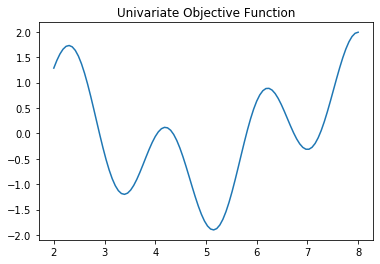

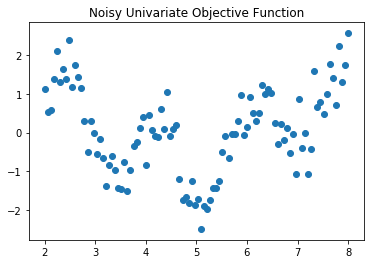

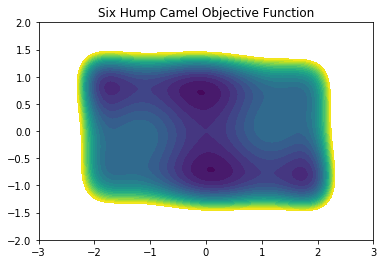

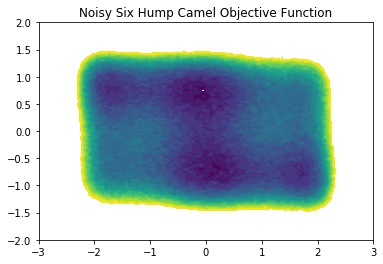

In [2]:
# Some examples of functions we are gonna work on and their noisy versions 

from objective_functions.six_hump_camel import SixHumpCamelObjectiveFunction
from objective_functions.univariate_objective_function import UnivariateObjectiveFunction

plt.title("Univariate Objective Function")
UnivariateObjectiveFunction().plot([100])

plt.title("Noisy Univariate Objective Function")
UnivariateObjectiveFunction(additional_gaussian_noise_std=0.5).plot([100])

plt.title("Six Hump Camel Objective Function")
SixHumpCamelObjectiveFunction().plot([100, 100])

plt.title("Noisy Six Hump Camel Objective Function")
SixHumpCamelObjectiveFunction(additional_gaussian_noise_std=0.3).plot([100, 100])

# Gaussian Processes

## Task 1: Gaussian Kernel (10 marks)

All the kernels we will use are in the folder `kernels/`. Each one of those is represented by a class inheriting from the abstract class `Kernel`.

### Task

Complete the definition of the function `get_covariance_matrix(X, Y)` in the file `kernels/gaussian_kernel.py`.

### Parameters

Here `X` and `Y` are two numpy arrays in which each row represents a point at which the objective function could be evaluated.

### Return

The function should return a numpy array `K` representing the covariance matrix of `X` and `Y`. In this coursework, we will mainly consider the single kernel / covariance function: the squared exponential (Gaussian / radial-basis-function) kernel:

$$ K = (k(\mathbf{x_p}, \mathbf{y_q}))_{p,q} = \left( \sigma_f^2 \exp\left( - \dfrac{1}{2l^2} \| \mathbf{x_p} - \mathbf{y_q}\|^2 \right) \right)_{p,q} $$

where: 
*  $\sigma_f$ is the amplitude of the latent function
*  $l$ corresponds to the length scale.

### Useful attributes

Each kernel object has at least 3 attributes which you can use to solve this task and the next ones:
*  $\ln{\sigma_f}$ 
*  $\ln{l}$
*  and $\ln{\sigma_n}$, the logarithm of the noise scale, which will be useful in tasks `2` and `5`.

## Task 2: Gaussian Process mean and standard deviation prediction (20 marks)

All the gaussian process specific functions are implemented in the `GaussianProcess` class, in the file `gaussian_process.py`.

### Task

Complete the definition of the function `get_gp_mean_std(new_data_points)` in `gaussian_process.py`.

### Parameters

The parameter `new_data_points` ($X^*$) is a numpy array  in which all the rows correspond to a data point at which the objective function can be evaluated. Its shape is $n$ x $p$ where: 
* $n$ is the number of points.
* $p$ is the number of coordinates for each point (and the number of variables of the objective function).

### Return

The function is supposed to return a Tuple of numpy arrays (`mean`, `std`):
*  `mean` ($m_{post}(\cdot)$) - A column vector (of shape $n$ x $1$). Its $i^{th}$ coordinate corresponds to the **posterior** mean estimated by the gaussian process for the $i^{th}$ row of the `new_data_points`.
*  `std` ($\sigma_{post}(\cdot)$) - a column vector (of shape $n$ x $1$). Its $i^{th}$ coordinate corresponds to the **posterior** standard deviation estimated by the gaussian process for the $i^{th}$ row of the `new_data_points`.

### Useful attributes

In order to compute those values, you will need to use some of the attributes of the `GaussianProcess` objects:
* `_array_dataset` ($X$) - The array of training data (each row is a data point at which the objective function can be evaluated).
* `_array_objective_function_values` ($y$) - The array of training data evaluations. It is a column vector whose $i^{th}$ element is the evaluation by the objective function of the $i^{th}$ row of `_array_dataset`.
*  `_covariance_matrix` ($k(X,X)$) - the covariance matrix of the training data.
*  `_kernel` ($k(\cdot; \cdot)$) - the kernel of the gaussian process.

------

Now, we have:
* a kernel, 
* a function for estimating the mean and standard deviation of a gaussian process. 
So, we can have a look at some Gaussian Process predictions for some values of $\sigma_f$, $l$ and $\sigma_n$.

On the graphs below:
* The  magenta line represents the predicted mean
* The red line represents the computation of mean + 3 * std
* The blue line represents the computation of mean - 3 * std
* The cyan line represents the (non-noisy) objective function
* The green markers '+' represent the dataset evaluations.

**If the Gaussian Process does not fit the dataset, it means that the kernel parameters are not appropriate. We will see how to tune them in task 5.** 

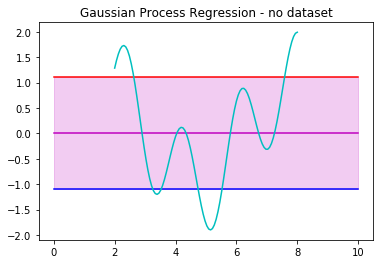

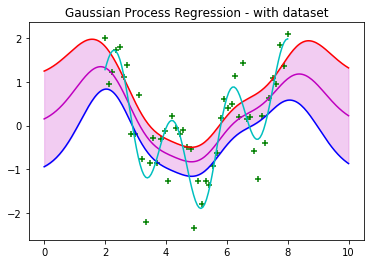

In [3]:
from gaussian_process import GaussianProcess
from kernels.gaussian_kernel import GaussianKernel

objective_function = UnivariateObjectiveFunction(additional_gaussian_noise_std=0.5)

kernel_gaussian = GaussianKernel(-1., 0., -1.)
gaussian_process = GaussianProcess(kernel_gaussian)

gaussian_process.plot(objective_function, show=False)
plt.title("Gaussian Process Regression - no dataset")
plt.show()

boundaries, = objective_function.boundaries
x = np.linspace(*boundaries, 50).reshape((-1, 1))
y = objective_function.evaluate(x).reshape((-1, 1))
gaussian_process.initialise_dataset(x, y)

gaussian_process.plot(objective_function, show=False)
plt.title("Gaussian Process Regression - with dataset")
plt.show()

## Task 3: Function Sampling (10 marks)

Technically, as a function contains infinitely many different variables, we cannot sample directly in the distribution of functions. 

However, we can still *simulate* a function sampling with the Gaussian Process by choosing $n$ points $(x^{(i)}_*)_{i=1..n}$ distributed evenly along the input space. Then we can simulate a "function sampling" by sampling using a multivariate normal distribution: 
$(x_i^*)_{i=1..n} \sim \mathcal{N}(\mu,\Sigma)$ where:
* $\mu = m_{post}(X_*)$
* $\Sigma = k(X_*, X_*)$

### Task

Implement a multivariate normal sampling in `get_sample(new_data_points)` in `gaussian_process.py`. 

### Parameters

As before, the parameter `new_data_points` ($X_*$) is a numpy array  in which all the rows correspond to a data point at which the objective function can be evaluated. Its shape is $n$ x $p$ where: 
* $n$ is the number of points.
* $p$ is the number of coordinates for each point (and the number of variables of the objective function).

### Returns

The function should return a multivariate normal sample of the objective function values. This is a sample from the distribution $\mathcal{N}(\mu,\Sigma)$.

-----

Once this function is defined you can have a look at the plots of such functions.

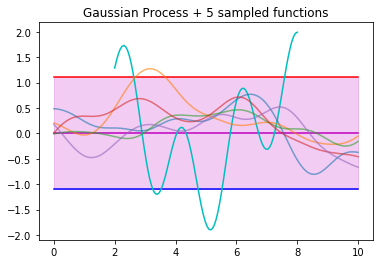

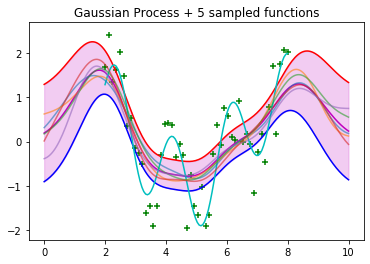

In [4]:
objective_function = UnivariateObjectiveFunction(additional_gaussian_noise_std=0.5)

kernel_gaussian = GaussianKernel(-1., 0., -1.)
gaussian_process = GaussianProcess(kernel_gaussian)

gaussian_process.plot_with_samples(5, objective_function)
plt.show()

boundaries, = objective_function.boundaries
x = np.linspace(*boundaries, 50).reshape((-1, 1))
y = objective_function.evaluate(x).reshape((-1, 1))
gaussian_process.initialise_dataset(x, y)

gaussian_process.plot_with_samples(5, objective_function)
plt.show()

## Task 4: Matern Kernel (10 marks)

The Gaussian Kernel used so far is used for approximating functions which are $C^\infty$ (having continuous derivatives of all orders). This explains the smoothness of the sampled functions seen before. 

If we want to use a 1-time differentiable Gaussian Process, we can use the **3/2 Matern Kernel** defined as:

$$ k_{Mat, 3/2}(\mathbf{x}, \mathbf{y}) = \sigma_f^2 \left( 1 + \dfrac{\sqrt{3}\|\mathbf{x} - \mathbf{y}\|}{l}\right) \exp\left(  - \dfrac{\sqrt{3}\|\mathbf{x} - \mathbf{y}\|}{l} \right) $$

----

### Task

Complete the definition of the function `get_covariance_matrix(X, Y)` in the file `kernels/matern_kernel.py`.


### Parameters

Here `X` and `Y` are two numpy arrays in which each row represents a point at which the objective function could be evaluated.

### Returns

The function should return a numpy array `K` representing the covariance matrix of `X` and `Y` for a **3/2 Matern Kernel**.

$$ K = (k(\mathbf{x_p}, \mathbf{y_q}))_{p,q} $$

-----

Once this function is defined you can have a look at the plots of functions sampled using this new kernel. 

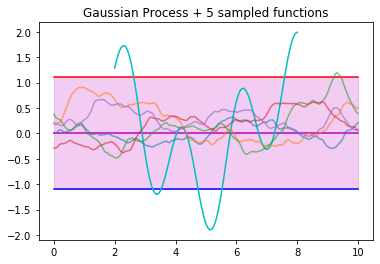

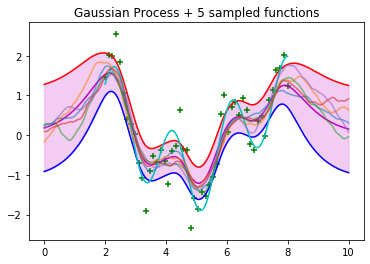

In [5]:
objective_function = UnivariateObjectiveFunction(additional_gaussian_noise_std=0.5)

from kernels.matern_kernel import MaternKernel

kernel_matern = MaternKernel(-1., 0., -1.)
gaussian_process = GaussianProcess(kernel_matern)

gaussian_process.plot_with_samples(5, objective_function)
plt.show()

boundaries, = objective_function.boundaries
x = np.linspace(*boundaries, 50).reshape((-1, 1))
y = objective_function.evaluate(x).reshape((-1, 1))
gaussian_process.initialise_dataset(x, y)

gaussian_process.plot_with_samples(5, objective_function)
plt.show()

## Task 5: Marginal Likelihood (20 marks)

So far, we have performed a gaussian process regression using some pre-defined kernel parameters. As you have seen in the previous examples, using inadequate parameters for the kernel may result in very poor performance regarding the regression. 

In order to find the optimal values for those parameters, we would like to maximise the *marginal likelihood* associated to the Gaussian Process.

In reality, we will try to minimise the *negative log marginal likelihood*, which is easier to estimate and optimise.

All the optimisation procedure is performed in the function `optimise_parameters()` of class `GaussianProcess`. This function is already written and does not require any further modification. To find the kernel parameters that minimise the *negative log marginal likelihood*, this `optimise_parameters()` function uses:
* A function which computes the *negative log marginal likelihood* : `get_negative_log_marginal_likelihood(log_amplitude, log_length_scale, log_noise_scale)`
* A function which computes its *gradient*: `get_gradient_negative_log_marginal_likelihood(log_amplitude, log_length_scale, log_noise_scale)`. This function is also already written and does not require any further modification.

### Task

Implement the method `get_negative_log_marginal_likelihood(log_amplitude, log_length_scale, log_noise_scale)` in `gaussian_process.py`.

### Parameters

* `log_amplitude`: $\log{\sigma_f}$
* `log_length_scale`: $\log{l}$
* `log_noise_scale`: $\log{\sigma_n}$

### Returns

This method returns the negative logarithm of the marginal likelihood corresponding to the gaussian process.

$$ -\log{p(y|X,\theta)} = \dfrac{1}{2}y^T K_\theta^{-1} y + \dfrac{1}{2} \log{|K_\theta|} + \dfrac{n}{2} \log{2\pi} $$

where $K_\theta = k(X, X) + \sigma_n^2 I$

### Useful functions

In addition to the previous shown functions and attributes, you may find the following ones useful in this task:
* `set_kernel_parameters(log_amplitude: float, log_length_scale: float, log_noise_scale: float)`


## Questions

Perform two Gaussian Process regressions as before: one with the gaussian kernel and one with the Matern Kernel.
Which one is the best? Why?

         Current function value: 54.504562
         Iterations: 7
         Function evaluations: 91
         Gradient evaluations: 79


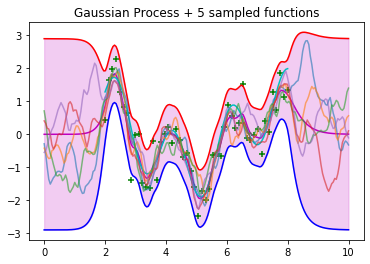

Optimization terminated successfully.
         Current function value: 48.761374
         Iterations: 12
         Function evaluations: 16
         Gradient evaluations: 16


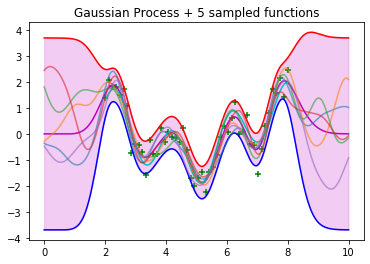

In [6]:
kernel_matern = MaternKernel(-1., 0., -1.)
gaussian_process = GaussianProcess(kernel_matern)

boundaries, = objective_function.boundaries
x = np.linspace(*boundaries, 50).reshape((-1, 1))
y = objective_function.evaluate(x).reshape((-1, 1))
gaussian_process.initialise_dataset(x, y)

opt_params = gaussian_process.optimise_parameters().x
log_amplitude, log_length_scale, log_noise_scale = opt_params
gaussian_process.set_kernel_parameters(log_amplitude, log_length_scale, log_noise_scale)

gaussian_process.plot_with_samples(5, objective_function)
plt.show()


kernel_g = GaussianKernel(-1., 0., -1.)
gaussian_process = GaussianProcess(kernel_g)

boundaries, = objective_function.boundaries
x = np.linspace(*boundaries, 50).reshape((-1, 1))
y = objective_function.evaluate(x).reshape((-1, 1))
gaussian_process.initialise_dataset(x, y)

opt_params = gaussian_process.optimise_parameters().x
log_amplitude, log_length_scale, log_noise_scale = opt_params
gaussian_process.set_kernel_parameters(log_amplitude, log_length_scale, log_noise_scale)

gaussian_process.plot_with_samples(5, objective_function)
plt.show()

## Task 6: Implement metrics, to measure performance on test set (10 marks)

Let's now implement a function to measure the performance of the optimised Gaussian Process on a test set. This way, we will be able to visualise how well it generalises to other data points.

As we are performing a regression task, we can try to measure the **log predictive density**, which estimates the accuracy of future data drawn from the same distribution.

### Task

Implement the method `get_log_predictive_density(data_points_test, evaluations_test)` in file `gaussian_process.py`

### Parameters

* `data_points_test` ($X_{test}$) - It is a numpy array  in which all the rows $(x^{(i)}_{test})_{i=1..n}$ correspond to a data point at which the objective function can be evaluated. Its shape is $n$ x $p$ where: 
    * $n$ is the number of points.
    * $p$ is the number of coordinates for each point (and the number of variables of the objective function).
* `evaluations_test` ($y_{test}$) - The array of test data evaluations. It is a column vector whose $i^{th}$ element corresponds to the evaluation by the objective function of $x^{(i)}_{test}$.

### Returns

It returns the log predictive density $lpd$ calculated using the test set:

$$lpd = \sum_{i=1}^{N_{test}} \log p(y^{(i)}_{test} | \mathbf{x}^{(i)}_{test}, X_{train}, \mathbf{y_{train}} )$$

----

Once this function is implemented, we can try to compute the log predictive dentisy for our initial dataset and our optimised matrix.

LPD Gaussian Process without marginal likelihood optimisation: -306.1079855547007


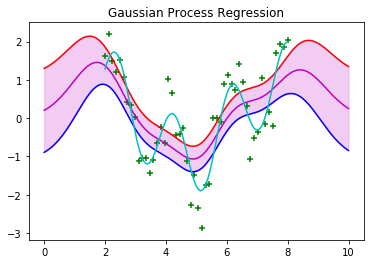

--------------------------------------------------
LPD optimised Gaussian Process: -120.14768478864619


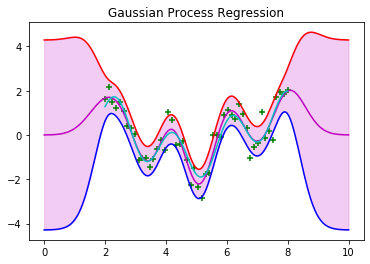

In [7]:
objective_function = UnivariateObjectiveFunction(additional_gaussian_noise_std=0.5)

from kernels.gaussian_kernel import GaussianKernel

kernel_gaussian = GaussianKernel(-1., 0., -1.)
gaussian_process = GaussianProcess(kernel_gaussian)

boundaries, = objective_function.boundaries
x_train = np.linspace(*boundaries, 50).reshape((-1, 1))
y_train = objective_function.evaluate(x_train).reshape((-1, 1))

x_test = np.linspace(*boundaries, 150).reshape((-1, 1))
y_test = objective_function.evaluate(x_test).reshape((-1, 1))


gaussian_process.initialise_dataset(x_train, y_train)
print(f"LPD Gaussian Process without marginal likelihood optimisation: {gaussian_process.get_log_predictive_density(x_test, y_test)}")
gaussian_process.plot(objective_function)

print('-' * 50)
gaussian_process.optimise_parameters(disp=False)

print(f"LPD optimised Gaussian Process: {gaussian_process.get_log_predictive_density(x_test, y_test)}")
gaussian_process.plot(objective_function)

# Bayesian Optimisation

## Task 7: Acquisition Function (10 marks)

Bayesian Optimisation is useful for optimising objective functions which are expensive to evaluate. To do so, it performs a regression on the objective function with a gaussian process and a limited number of points. Then it optimises a surrogate function which is easy to evaluate: the `acquisition function`. It's computed argmax tells us where to evaluate our black-box objective function at the next step.

All the acquisition functions are represented by classes inheriting from the abstract class `AcquisitionFunction`. All of them are in the folder `acquisition_functions/`. The Lower-Confidence Bound acquisition function is already fully implemented.

### Task

The goal of this task is to implement another one: the Expected Improvement acquisition function. 
Complete the definition of the function `_evaluate(gaussian_process, data_points)` in `acquisition_functions/gaussian_process.py`

### Parameters

The function takes 2 input variables:
* a Gaussian Process, as the acquisition functions depend on the mean and std predicted by the Gaussian Process
* `data_points` - The array of training data (each row is a data point $(x_i)_{i=1..n}$ at which the acquisition function will be evaluated). Its shape is written $n$ x $p$.

### Returns

A numpy array of shape $n$ x $1$ (it is a vector column). The value at its $i^{th}$ position corresponds to the value taken by the acquisition function at $x_i$


-----

Now, we have all the ingredients ready for performing a Bayesian Optimisation

## Task 8: Bayesian Optimisation (10 marks)

The Bayesian Optimisation algorithm, and all the functions which have something to do with it are grouped in the class `BayesianOptimisation` of the file `bayesian_optimisation.py`.

Most of the code is already provided. All the algorithm is implemented in the `run` method. The only method which remains to be completed is the `_bayesian_optimisation_step` method (called in the main loop of `run`).

### Task

Complete the definition of the method `_bayesian_optimisation_step` in the file `bayesian_optimisation.py`.

### Description

* The single argument of the `_bayesian_optimisation_step` method corresponds to the last computed argmax of the acquisition function.
* Update the gaussian process by using this new point.
* Optimise the Gaussian Process
* Compute and return the next point at which we will evaluate the objective function.

### Some useful methods

You may need to use the method `compute_arg_max` implemented in the `Acquisition Function` abstract class.

-----

You may find below some code for showing the detailed steps of a Bayesian Optimisation for some objective functions.


Initialising Dataset with 1 Initial Elements
Launching Bayesian Optimisation with 25 Steps
Step 0/25 - Initialise Gaussian Process for Provided Dataset
Step 0/25 - Evaluating Objective Function at position [4.121212121212121]
Optimization terminated successfully.
         Current function value: 0.652167
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
((2.0, 8.0),)


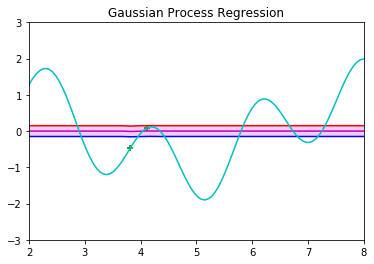

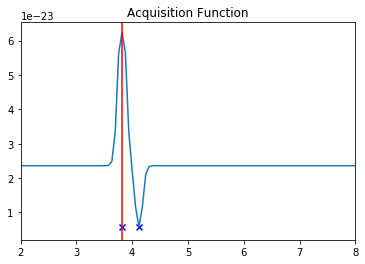

Step 1/25 - Evaluating Objective Function at position [3.8181818181818183]
         Current function value: -0.743407
         Iterations: 5
         Function evaluations: 71
         Gradient evaluations: 59
((2.0, 8.0),)


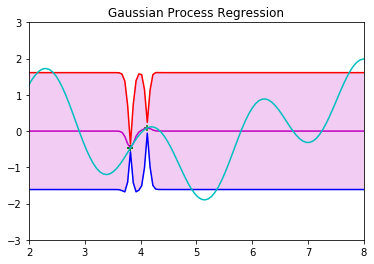

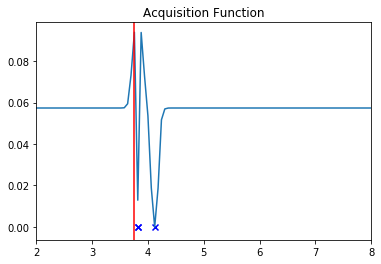

Step 2/25 - Evaluating Objective Function at position [3.757575757575758]
         Current function value: -1.227726
         Iterations: 3
         Function evaluations: 49
         Gradient evaluations: 38
((2.0, 8.0),)


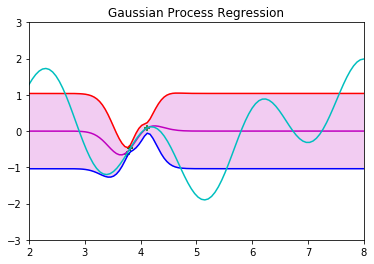

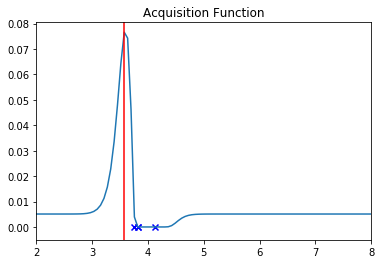

Step 3/25 - Evaluating Objective Function at position [3.5757575757575757]
         Current function value: -1.762239
         Iterations: 3
         Function evaluations: 41
         Gradient evaluations: 29
((2.0, 8.0),)


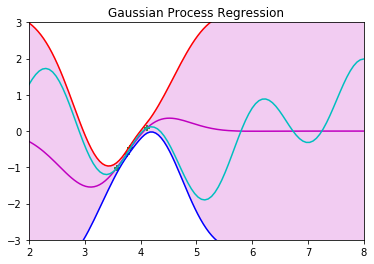

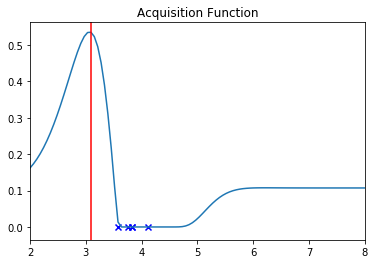

Step 4/25 - Evaluating Objective Function at position [3.090909090909091]
         Current function value: -1.247546
         Iterations: 2
         Function evaluations: 107
         Gradient evaluations: 95
((2.0, 8.0),)


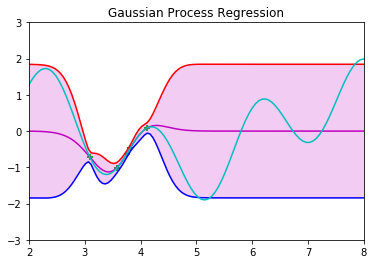

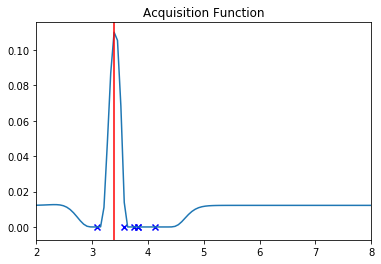

Step 5/25 - Evaluating Objective Function at position [3.393939393939394]
         Current function value: -2.537117
         Iterations: 1
         Function evaluations: 44
         Gradient evaluations: 32
((2.0, 8.0),)


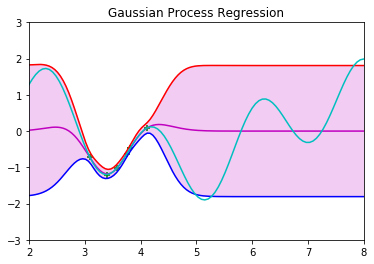

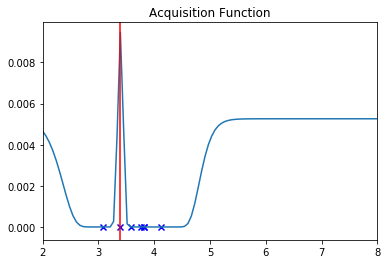

Step 6/25 - Evaluating Objective Function at position [3.393939393939394]
         Current function value: -4.301215
         Iterations: 0
         Function evaluations: 39
         Gradient evaluations: 27
((2.0, 8.0),)


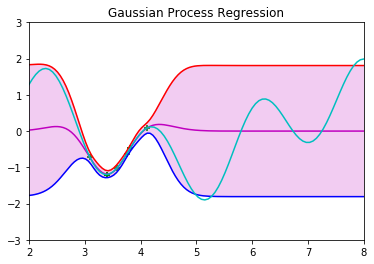

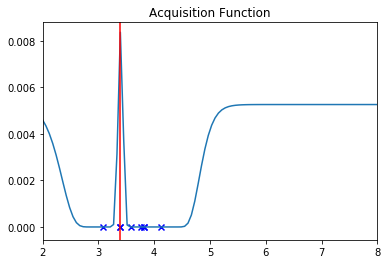

Step 7/25 - Evaluating Objective Function at position [3.393939393939394]
         Current function value: -6.188987
         Iterations: 0
         Function evaluations: 40
         Gradient evaluations: 28
((2.0, 8.0),)


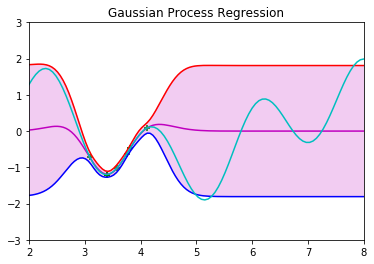

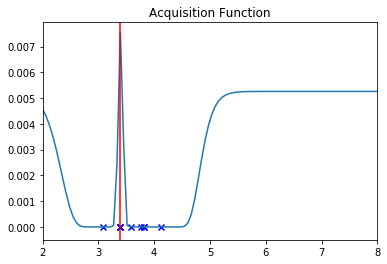

Step 8/25 - Evaluating Objective Function at position [3.393939393939394]
         Current function value: -8.130795
         Iterations: 0
         Function evaluations: 41
         Gradient evaluations: 29
((2.0, 8.0),)


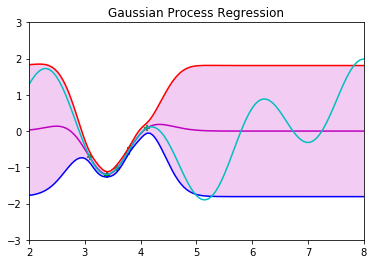

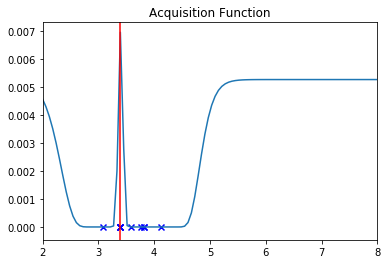

Step 9/25 - Evaluating Objective Function at position [3.393939393939394]
         Current function value: -10.102984
         Iterations: 0
         Function evaluations: 45
         Gradient evaluations: 33
((2.0, 8.0),)


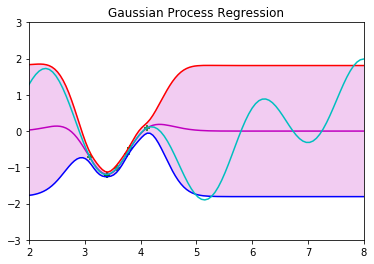

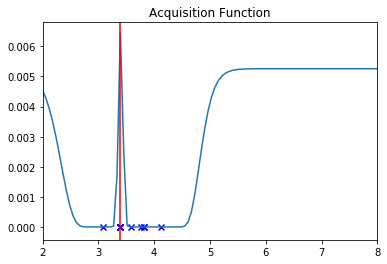

Step 10/25 - Evaluating Objective Function at position [3.393939393939394]
         Current function value: -12.094660
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 40
((2.0, 8.0),)


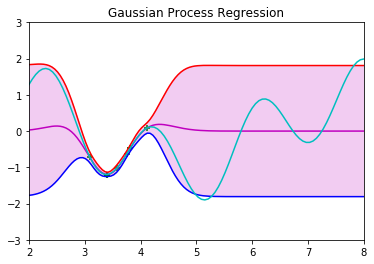

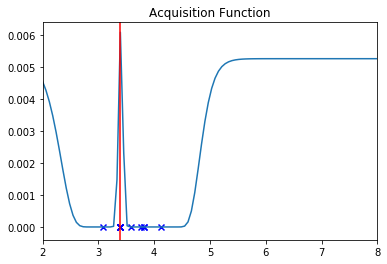

Step 11/25 - Evaluating Objective Function at position [3.393939393939394]
         Current function value: -14.099901
         Iterations: 0
         Function evaluations: 51
         Gradient evaluations: 39
((2.0, 8.0),)


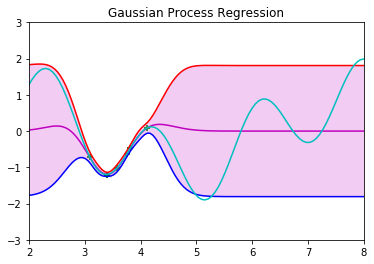

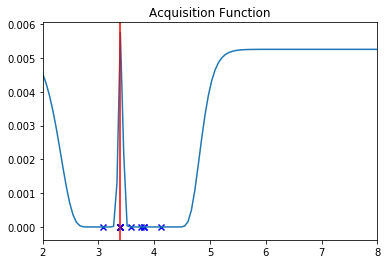

Step 12/25 - Evaluating Objective Function at position [3.393939393939394]
         Current function value: -16.115131
         Iterations: 0
         Function evaluations: 42
         Gradient evaluations: 30
((2.0, 8.0),)


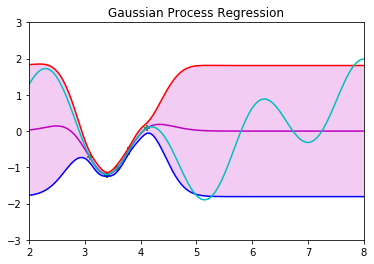

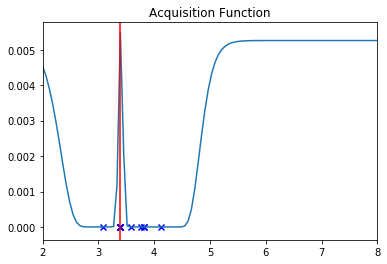

Step 13/25 - Evaluating Objective Function at position [3.393939393939394]
         Current function value: -18.138023
         Iterations: 0
         Function evaluations: 43
         Gradient evaluations: 31
((2.0, 8.0),)


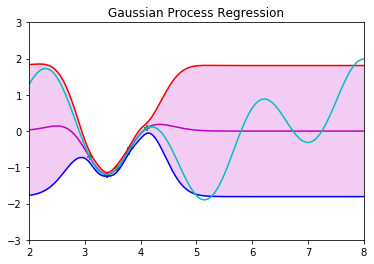

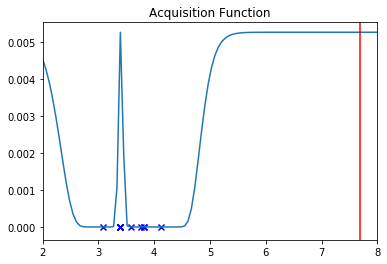

Step 14/25 - Evaluating Objective Function at position [7.696969696969697]
         Current function value: -15.639999
         Iterations: 1
         Function evaluations: 46
         Gradient evaluations: 36
((2.0, 8.0),)


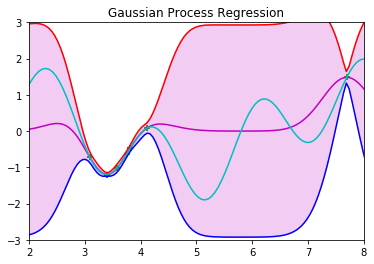

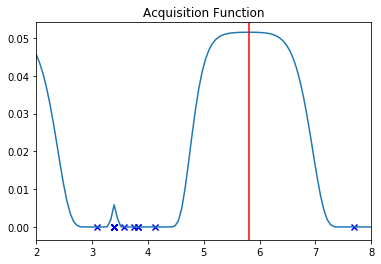

Step 15/25 - Evaluating Objective Function at position [5.818181818181818]
         Current function value: -14.941287
         Iterations: 1
         Function evaluations: 107
         Gradient evaluations: 95
((2.0, 8.0),)


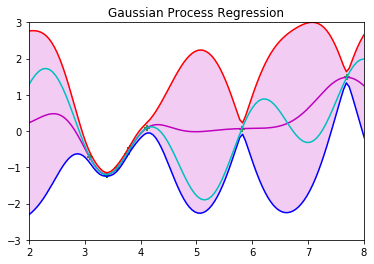

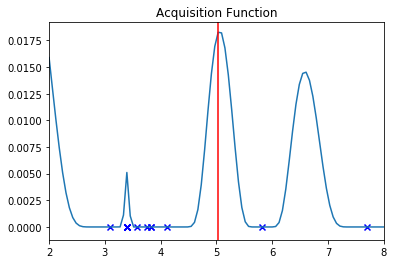

Step 16/25 - Evaluating Objective Function at position [5.03030303030303]
         Current function value: -12.017037
         Iterations: 1
         Function evaluations: 52
         Gradient evaluations: 42
((2.0, 8.0),)


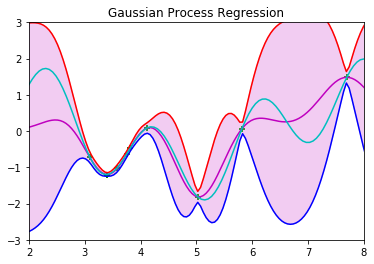

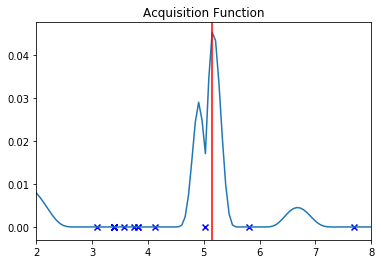

Step 17/25 - Evaluating Objective Function at position [5.151515151515151]
         Current function value: -12.429855
         Iterations: 0
         Function evaluations: 41
         Gradient evaluations: 29
((2.0, 8.0),)


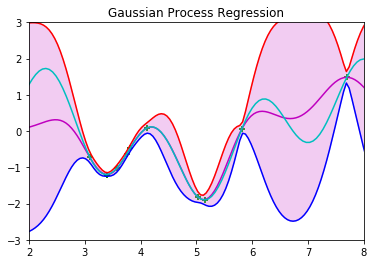

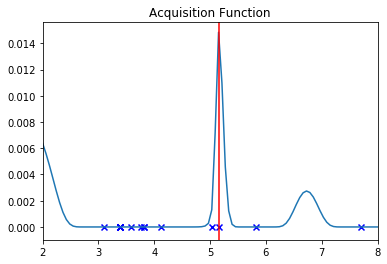

Step 18/25 - Evaluating Objective Function at position [5.151515151515151]
         Current function value: -14.170998
         Iterations: 0
         Function evaluations: 42
         Gradient evaluations: 31
((2.0, 8.0),)


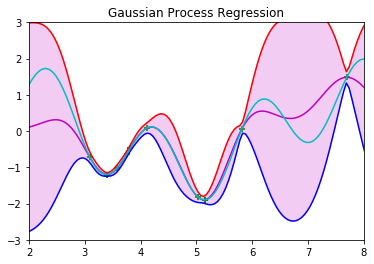

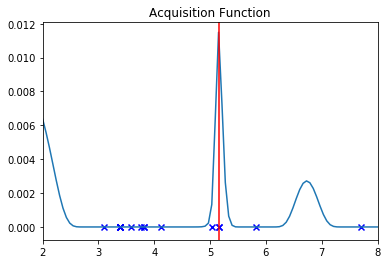

Step 19/25 - Evaluating Objective Function at position [5.151515151515151]
         Current function value: -16.051524
         Iterations: 0
         Function evaluations: 46
         Gradient evaluations: 34
((2.0, 8.0),)


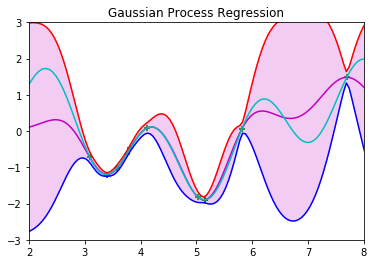

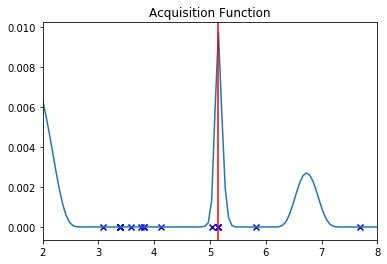

Step 20/25 - Evaluating Objective Function at position [5.151515151515151]
         Current function value: -17.989838
         Iterations: 0
         Function evaluations: 49
         Gradient evaluations: 37
((2.0, 8.0),)


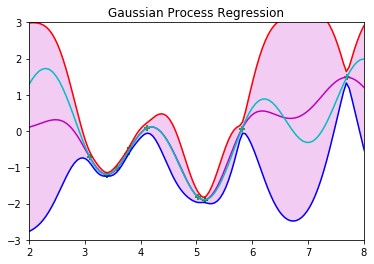

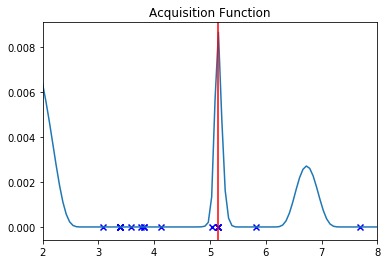

Step 21/25 - Evaluating Objective Function at position [5.151515151515151]
         Current function value: -19.959983
         Iterations: 0
         Function evaluations: 46
         Gradient evaluations: 34
((2.0, 8.0),)


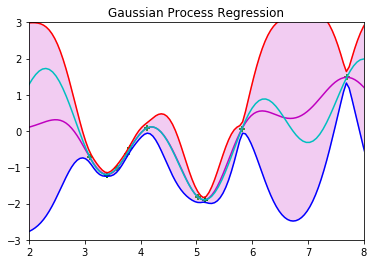

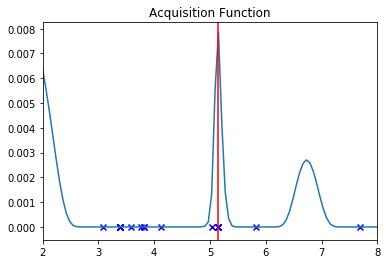

Step 22/25 - Evaluating Objective Function at position [5.151515151515151]
         Current function value: -21.950320
         Iterations: 0
         Function evaluations: 45
         Gradient evaluations: 33
((2.0, 8.0),)


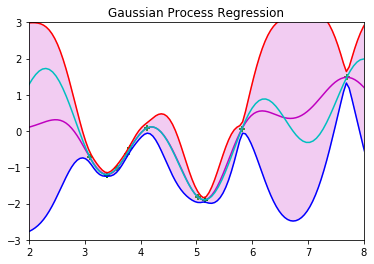

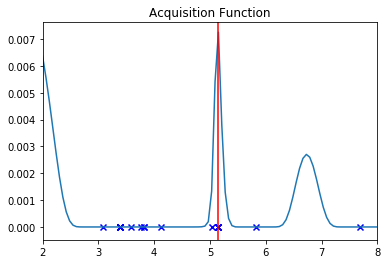

Step 23/25 - Evaluating Objective Function at position [5.151515151515151]
         Current function value: -23.954617
         Iterations: 0
         Function evaluations: 42
         Gradient evaluations: 30
((2.0, 8.0),)


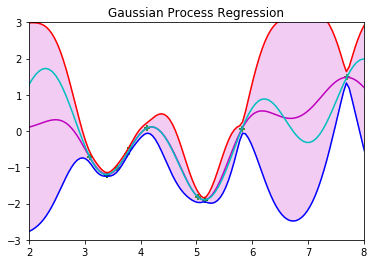

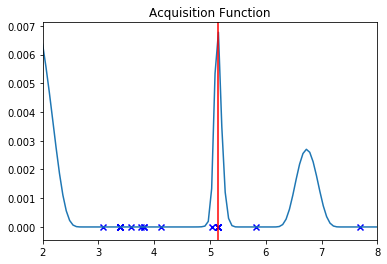

Step 24/25 - Evaluating Objective Function at position [5.151515151515151]
         Current function value: -25.969146
         Iterations: 0
         Function evaluations: 45
         Gradient evaluations: 33
((2.0, 8.0),)


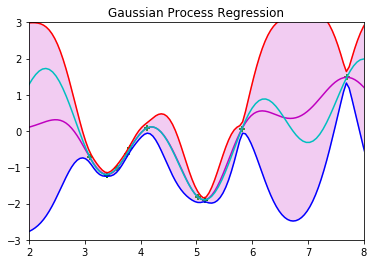

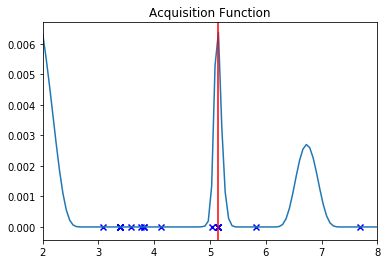

Best argmin found for the objective function: [5.15151515]


In [8]:
#---------------
# Bayesian Optimisation in 1 dimension
#---------------

import objective_functions
from acquisition_functions.expected_improvement import ExpectedImprovement

kernel = GaussianKernel(-1., -1., -1.)

objective_function = objective_functions.univariate_objective_function.UnivariateObjectiveFunction()
# objective_function = objective_functions.six_hump_camel.SixHumpCamelObjectiveFunction()

# acquisition_function = LowerConfidenceBound(2.)
acquisition_function = ExpectedImprovement()

bayesian_optimisation = BayesianOptimisation(
    kernel,
    objective_function,
    acquisition_function
)

number_initial_elements = 1
print(f"Initialising Dataset with {number_initial_elements} Initial Elements")
dataset = objective_function.get_random_initial_dataset(number_initial_elements)
evaluations = objective_function.evaluate(dataset)

number_steps_bayesian_optimisation = 25
print(f"Launching Bayesian Optimisation with {number_steps_bayesian_optimisation} Steps")

bo_generator = bayesian_optimisation.run(
    number_steps=number_steps_bayesian_optimisation,
    array_initial_dataset=dataset,
    array_initial_objective_function_values=evaluations
)

for gp, aq, arg_max_aq in bo_generator:
    print(objective_function.boundaries)
    boundaries_x, = objective_function.boundaries
    plt.xlim(boundaries_x)
    plt.ylim(-3., 3.)

    gp.plot(objective_function)
    
    plt.xlim(boundaries_x)
    aq.plot(gp, objective_function, last_evaluated_point=arg_max_aq)

print(f"Best argmin found for the objective function: {bayesian_optimisation.get_best_data_point()}")


In [ ]:
#---------------
# Bayesian Optimisation in 2 dimensions
#---------------


from acquisition_functions.expected_improvement import ExpectedImprovement

kernel = GaussianKernel(0.5, np.log(1.), 1*np.log(1.))

# objective_function = objective_functions.univariate_objective_function.UnivariateObjectiveFunction()
objective_function = objective_functions.six_hump_camel.SixHumpCamelObjectiveFunction()

# acquisition_function = LowerConfidenceBound(2.)
acquisition_function = ExpectedImprovement()

bayesian_optimisation = BayesianOptimisation(
    kernel,
    objective_function,
    acquisition_function
)

number_initial_elements = 4
print(f"Initialising Dataset with {number_initial_elements} Initial Elements")
dataset = objective_function.get_random_initial_dataset(number_initial_elements)
evaluations = objective_function.evaluate(dataset)

number_steps_bayesian_optimisation = 25
print(f"Launching Bayesian Optimisation with {number_steps_bayesian_optimisation} Steps")

bo_generator = bayesian_optimisation.run(
    number_steps=number_steps_bayesian_optimisation,
    array_initial_dataset=dataset,
    array_initial_objective_function_values=evaluations
)

for gp, aq, arg_max_aq in bo_generator:
    print(objective_function.boundaries)
    boundaries_x, boundaries_y = objective_function.boundaries
    plt.xlim(boundaries_x)
    plt.ylim(boundaries_y)
    gp.plot(objective_function)
    
    plt.xlim(boundaries_x)
    aq.plot(gp, objective_function, last_evaluated_point=arg_max_aq)

print(f"Best argmin found for the objective function: {bayesian_optimisation.get_best_data_point()}")



Initialising Dataset with 4 Initial Elements
Launching Bayesian Optimisation with 25 Steps
Step 0/25 - Initialise Gaussian Process for Provided Dataset


### Questions

What happens if there is not enough data provided at the Initialisation Step?

In [ ]:
# Code for your tests